In [1]:
import pandas as pd
import os
import boto3
import botocore
from dotenv import load_dotenv
from pycaret.regression import setup, compare_models, finalize_model, plot_model, save_model

In [56]:
file_path = 'dane/dane_dla_modelu/halfmarathon_wroclaw_23_24.csv'
df = pd.read_csv(file_path, sep=';')
df.sample(5)

,Czas,Wiek,Płeć,5 km Czas
14996,7871.0,37,M,1741.0
5337,7705.0,37,M,1842.0
17357,9051.0,37,K,1969.0
16650,8593.0,44,K,1856.0
7621,9382.0,28,M,1832.0


### 1. Trenowanie modelu (dobór odpowiednich metryk [feature selection])

In [57]:
s = setup(
    data=df, 
    target='Czas',
    session_id=123,
    normalize=True,
    train_size=0.8, # 80% danych do trenowania modelu, a 20% do testowania
    fold=5,
)

,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(18411, 4)"
4,Transformed data shape,"(18411, 4)"
5,Transformed train set shape,"(14728, 4)"
6,Transformed test set shape,"(3683, 4)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


In [58]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,304.0591,179225.4061,423.1680,0.8799,0.0532,0.0395,0.0960
lightgbm,Light Gradient Boosting Machine,307.2818,182612.1350,427.2148,0.8776,0.0537,0.0400,0.1460
lasso,Lasso Regression,307.4322,191316.0705,437.2167,0.8718,0.0588,0.0399,0.4060
ridge,Ridge Regression,307.4003,191326.4149,437.2277,0.8718,0.0588,0.0399,0.4140
lar,Least Angle Regression,307.3964,191326.3929,437.2276,0.8718,0.0587,0.0399,0.3860
llar,Lasso Least Angle Regression,307.4323,191316.0627,437.2167,0.8718,0.0588,0.0399,0.0160
omp,Orthogonal Matching Pursuit,307.4305,191303.0793,437.2006,0.8718,0.0588,0.0399,0.0140
br,Bayesian Ridge,307.3981,191326.4177,437.2276,0.8718,0.0587,0.0399,0.0140
lr,Linear Regression,307.3964,191326.3929,437.2276,0.8718,0.0587,0.0399,0.5320
huber,Huber Regressor,302.7028,193767.9827,440.0115,0.8702,0.0589,0.0390,0.0180


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

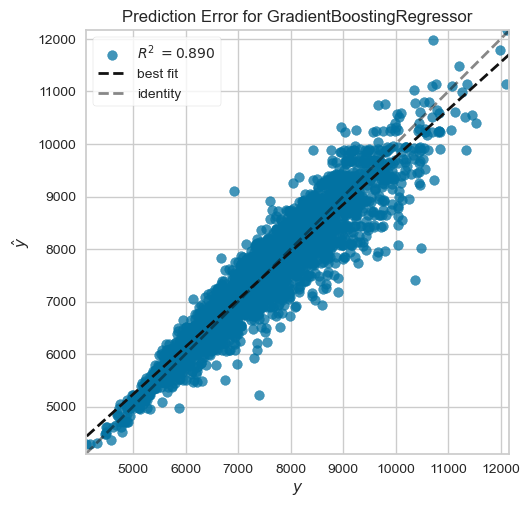

In [59]:
plot_model(best_model, plot='error')

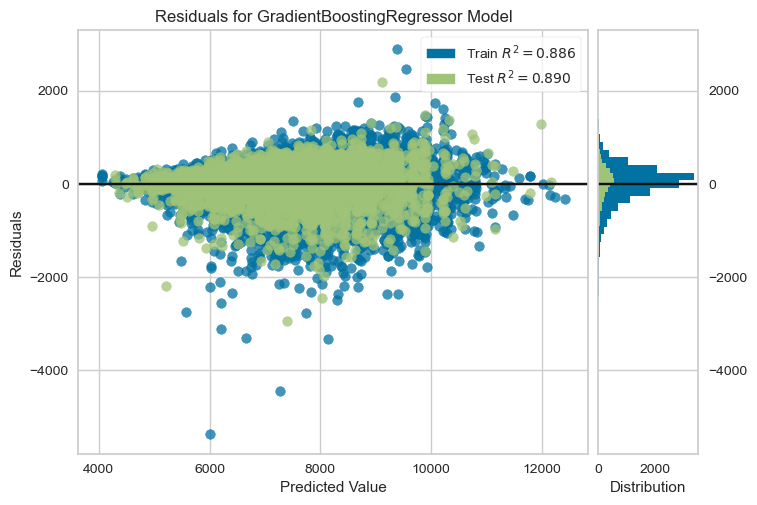

In [60]:
plot_model(best_model, plot='residuals')

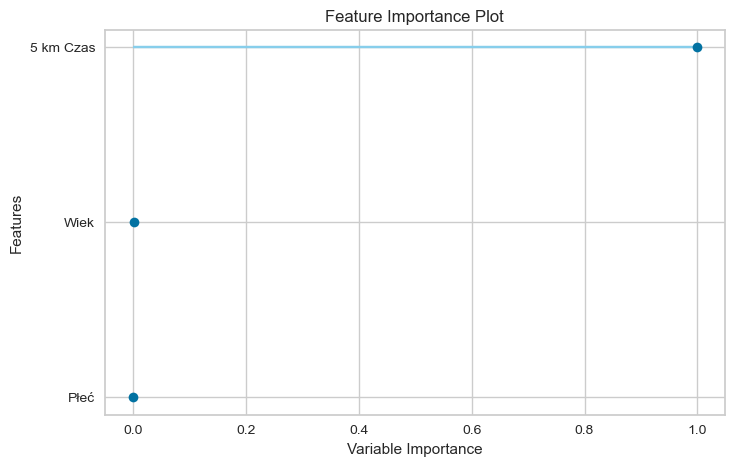

In [61]:
plot_model(best_model, plot='feature')

### 2. Zapis nowej wersji modelu lokalnie i do Digital Ocean Spaces

#### 2.1 Lokalnie

In [63]:
final_best = finalize_model(best_model)
os.makedirs('model/new', exist_ok=True)
save_model(final_best, 'model/new/best_marathon_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Wiek', '5 km Czas'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=OrdinalEncoder(cols=['Płeć'],
                                                                handle_missing='return_nan',
                                                                mapping=[{'col': 'Płeć',
                                                                          'data_type': dtype('O'),
                                                                          'mapping': K      0
 M      1
 NaN   -1
 dtype: int64}]))),
          

#### 2.1 DOS

In [2]:
load_dotenv()
s3 = boto3.client('s3',)
BUCKET_NAME = "half-marathon"

In [3]:
# Ścieżka do lokalnego katalogu
local_directory = 'model'

# Przechodzimy przez wszystkie pliki i podfoldery w katalogu 'model'
for root, dirs, files in os.walk(local_directory):
    for filename in files:
        # Tworzymy pełną ścieżkę do pliku na dysku lokalnym
        local_path = os.path.join(root, filename)
        
        # Wyznaczamy ścieżkę względną, aby zachować strukturę folderów w chmurze
        # os.path.dirname(local_directory) sprawia, że folder 'model' będzie folderem głównym w Spaces
        relative_path = os.path.relpath(local_path, os.path.dirname(local_directory))
        
        # S3 wymaga slashy (/) jako separatorów, niezależnie od systemu operacyjnego
        s3_path = relative_path.replace("\\", "/")
        
        try:
            # Próba pobrania metadanych pliku z Digital Ocean Spaces
            # Jeśli plik istnieje, ta funkcja zakończy się sukcesem
            s3.head_object(Bucket=BUCKET_NAME, Key=s3_path)
            # Jeśli kod doszedł tutaj, plik już jest w Spaces, więc go pomijamy
            print(f"Pomijanie (już istnieje): {s3_path}")
            
        except botocore.exceptions.ClientError as e:
            # Jeśli wystąpił błąd, sprawdzamy czy to błąd 404 (brak pliku)
            if e.response['Error']['Code'] == "404":
                # Pliku nie ma w chmurze, więc przystępujemy do wysyłki
                print(f"Przesyłanie nowego pliku: {local_path} -> {s3_path}...")
                s3.upload_file(local_path, BUCKET_NAME, s3_path)
            else:
                # Jeśli wystąpił inny błąd (np. błąd połączenia lub uprawnień), rzucamy wyjątek
                print(f"Wystąpił nieoczekiwany błąd przy pliku {s3_path}: {e}")
                raise e

print("--- Synchronizacja katalogu zakończona ---")

Pomijanie (już istnieje): model/new/best_marathon_model.pkl
--- Synchronizacja katalogu zakończona ---
